In [1]:
!pip install scikit-optimize

In [2]:
from Library import load_datasets
from Library import eth_data_manager
import numpy as np
np.random.seed(123)
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [3]:
# Load dataset
trajs,trajs_hotel = load_datasets()

In [4]:
# Get different data
obs = 8
train_range = range(obs)
pred_pos = 15

X_x, y_x, X_y, y_y = eth_data_manager(trajs,train_range,pred_pos,multi_output=False)

In [5]:
X_x_train, X_x_test, y_x_train, y_x_test = train_test_split(
            X_x, y_x, test_size=0.25, random_state=42)
X_y_train, X_y_test, y_y_train, y_y_test = train_test_split(
            X_y, y_y, test_size=0.25, random_state=42)

obs 8 coords -> pred 1 coord (8th next frame)

In [6]:
X = np.hstack((X_x, X_y))
y = np.vstack((y_x, y_y)).T

X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.25, random_state=42)

In [7]:
X_train[2,:obs], X_train[2,obs:]

(array([-2.7031197 , -2.0261693 , -1.3110684 , -0.61248492,  0.02963486,
         0.65402582,  1.4394241 ,  2.0807779 ]),
 array([5.7270695, 5.8871157, 5.9958492, 6.0568709, 6.2100517, 6.2707036,
        6.5900406, 6.511591 ]))

# Hyperparam search wrapper

https://scikit-optimize.github.io/stable/auto_examples/sklearn-gridsearchcv-replacement.html

In [8]:
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from skopt.plots import plot_objective, plot_histogram

from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVR, SVR
#from sklearn.multioutput import MultiOutputRegressor
import copy

TOO SLOW!

In [9]:
opt = BayesSearchCV(
    SVR(),
    {
        'C': (1e-6, 1e+5, 'log-uniform'),
        'gamma': (1e-6, 1e+1, 'log-uniform'),
        'degree': (1, 4),  # integer valued parameter
        'kernel': ['linear', 'poly', 'rbf'],  # categorical parameter
    },
    n_iter=10,
    cv=3
)

opt_x = copy.deepcopy(opt)
opt_x.fit(X_x_train, y_x_train)

print("val. score: %s" % opt_x.best_score_)
print("test score: %s" % opt_x.score(X_x_test, y_x_test))
print("best params: %s" % str(opt_x.best_params_))
print(opt_x.total_iterations)

In [ ]:
opt_y = copy.deepcopy(opt)
opt_y.fit(X_y_train, y_y_train)

print("val. score: %s" % opt_y.best_score_)
print("test score: %s" % opt_y.score(X_y_test, y_y_test))
print("best params: %s" % str(opt_y.best_params_))
print(opt_y.total_iterations)

In [ ]:
_ = plot_objective(opt_x.optimizer_results_[0],
                   dimensions=["C", "degree", "gamma", "kernel"],
                   n_minimum_search=int(1e8))
plt.show()

In [ ]:
_ = plot_histogram(opt_x.optimizer_results_[1], 1)
plt.show()

# Tuning estimator (same as above but using skopt func)

https://scikit-optimize.github.io/stable/auto_examples/hyperparameter-optimization.html

In [9]:
from sklearn.model_selection import cross_val_score
from skopt.space import Real, Integer
from skopt.utils import use_named_args
from skopt.space import Real, Categorical, Integer
from sklearn.svm import SVR

In [13]:
reg = SVR()

# The list of hyper-parameters we want to optimize. For each one we define the
# bounds, the corresponding scikit-learn parameter name, as well as how to
# sample values from that dimension (`'log-uniform'` for C)
space  = [Real(1e-6, 1e+6, 'log-uniform', name='C'),
          Real(1e-6, 1e+1, "log-uniform", name='gamma'),
          Integer(1, 5, name='degree'),
          Categorical(['linear', 'poly', 'rbf'], name='kernel')]

# this decorator allows your objective function to receive a the parameters as
# keyword arguments. This is particularly convenient when you want to set
# scikit-learn estimator parameters
@use_named_args(space)
def objective(**params):
    reg.set_params(**params)

    return (-np.mean(cross_val_score(reg, X_x_train, y_x_train, cv=3, n_jobs=-1,
                                    scoring="neg_mean_squared_error")) -np.mean(
                    cross_val_score(reg, X_y_train, y_y_train, cv=3, n_jobs=-1,
                                    scoring="neg_mean_squared_error"))) / 2.0

In [11]:
from skopt import gp_minimize

This one is faster, but my laptop is still slow

In [14]:
res_gp = gp_minimize(objective, space, n_calls=10, random_state=0)

"Best score=%.4f" % res_gp.fun

'Best score=0.5263'

score of 0.53, but it is for both x and y??

In [21]:
print("""Best parameters:
- C=%.6f
- gamma=%.6f
- degree=%d
- kernel=%a""" % (res_gp.x[0], res_gp.x[1],
                            res_gp.x[2], res_gp.x[3]))

Best parameters:
- C=30.392356
- gamma=0.000491
- degree=2
- kernel='linear'


<AxesSubplot:title={'center':'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

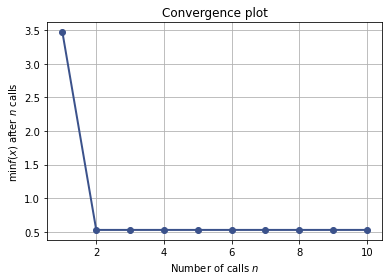

In [17]:
from skopt.plots import plot_convergence

plot_convergence(res_gp)

## Linear SVR

Fast! And divide objective by 2

In [40]:
reg = LinearSVR()#dual=False)

# The list of hyper-parameters we want to optimize. For each one we define the
# bounds, the corresponding scikit-learn parameter name, as well as how to
# sample values from that dimension (`'log-uniform'` for C)
space  = [Real(1e-5, 1e+5, 'log-uniform', name='C'),
          Real(1e-6, 1e+1, "log-uniform", name='epsilon'),
          Categorical(['epsilon_insensitive', 'squared_epsilon_insensitive'], name='loss')]

# this decorator allows your objective function to receive a the parameters as
# keyword arguments. This is particularly convenient when you want to set
# scikit-learn estimator parameters
@use_named_args(space)
def objective(**params):
    reg.set_params(**params)

    return (-np.mean(cross_val_score(reg, X_x_train, y_x_train, cv=3, n_jobs=-1,
                                    scoring="neg_mean_squared_error")) -np.mean(
                    cross_val_score(reg, X_y_train, y_y_train, cv=3, n_jobs=-1,
                                    scoring="neg_mean_squared_error"))) /2.0

In [41]:
new_res_gp = gp_minimize(objective, space, n_calls=50, random_state=0)

"Best score=%.4f" % new_res_gp.fun

'Best score=0.2772'

In [42]:
print("""Best parameters:
- C=%.6f
- epsilon=%.6f
- loss=%a""" % (new_res_gp.x[0], new_res_gp.x[1],
                            new_res_gp.x[2]))

Best parameters:
- C=0.555315
- epsilon=0.000001
- loss='squared_epsilon_insensitive'


<AxesSubplot:title={'center':'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

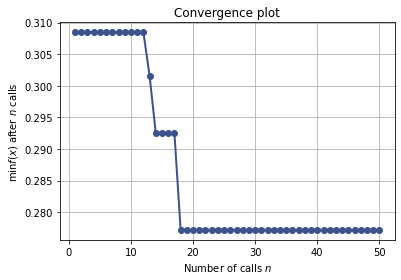

In [43]:
plot_convergence(new_res_gp)

## SVR

In [44]:
reg = SVR(kernel='linear')

# The list of hyper-parameters we want to optimize. For each one we define the
# bounds, the corresponding scikit-learn parameter name, as well as how to
# sample values from that dimension (`'log-uniform'` for C)
space  = [Real(1e-5, 1e+5, 'log-uniform', name='C'),
          Real(1e-6, 1e+1, "log-uniform", name='epsilon')]

# this decorator allows your objective function to receive a the parameters as
# keyword arguments. This is particularly convenient when you want to set
# scikit-learn estimator parameters
@use_named_args(space)
def objective(**params):
    reg.set_params(**params)

    return (-np.mean(cross_val_score(reg, X_x_train, y_x_train, cv=3, n_jobs=-1,
                                    scoring="neg_mean_squared_error")) -np.mean(
                    cross_val_score(reg, X_y_train, y_y_train, cv=3, n_jobs=-1,
                                    scoring="neg_mean_squared_error"))) / 2.0

In [45]:
res_gp = gp_minimize(objective, space, n_calls=50, random_state=0)

"Best score=%.4f" % res_gp.fun

'Best score=0.2563'

In [46]:
print("""Best parameters:
- C=%.6f
- epsilon=%.6f""" % (res_gp.x[0], res_gp.x[1]))

Best parameters:
- C=20.608161
- epsilon=0.000002


<AxesSubplot:title={'center':'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

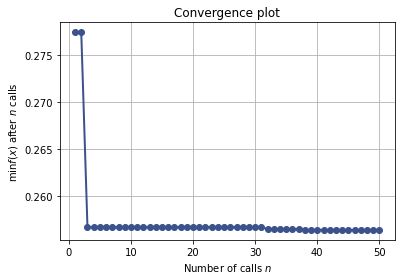

In [47]:
plot_convergence(res_gp)